In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.linear_model import LinearRegression

# ==================== CONFIGURACIÓN ====================
CORR_UMBRAL = 0.70
MIN_POINTS_REGRESSION = 30  # Reducido de 100 a 30 (más permisivo)
OUTPUT_FILE_BASE = 'cundinamarca_imputado'

# Rangos físicos realistas para Cundinamarca
RANGOS_FISICOS = {
    'TMin': (-10, 30),
    'TMax': (5, 40),
    'PREC': (0, 300),
    'HRMAX': (0, 100),
    'WS2M_MAX': (0, 50)
}

# ==================== FUNCIONES DE UTILIDAD ====================

def obtener_version_archivo(directorio, nombre_base):
    """Genera un nombre de archivo con versión incremental."""
    archivos_existentes = list(directorio.glob(f"{nombre_base}_v*.csv"))
    if not archivos_existentes:
        return f"{nombre_base}_v1.csv"
    versiones = []
    for archivo in archivos_existentes:
        try:
            version_str = archivo.stem.split('_v')[-1]
            versiones.append(int(version_str))
        except:
            continue
    nueva_version = max(versiones) + 1 if versiones else 1
    return f"{nombre_base}_v{nueva_version}.csv"

def extraer_tipo_variable(nombre_columna):
    """
    Extrae el tipo de variable de un nombre de columna.
    Ej: 'TMin_21205420_-_TIBAITATA' -> 'TMin'
    """
    return nombre_columna.split('_')[0]

def validar_rangos_fisicos(df, columnas_imputadas):
    """
    Valida que los valores estén dentro de rangos físicos realistas.
    """
    correcciones = 0
    for col in columnas_imputadas:
        var_type = extraer_tipo_variable(col)
        if var_type in RANGOS_FISICOS:
            lower, upper = RANGOS_FISICOS[var_type]
            
            # Contar valores fuera de rango
            fuera_rango = ((df[col] < lower) | (df[col] > upper)).sum()
            
            if fuera_rango > 0:
                df[col] = np.clip(df[col], lower, upper)
                correcciones += fuera_rango
    
    return correcciones

def validar_tmin_tmax(df):
    """
    Valida que TMin < TMax para cada estación en cada fecha.
    """
    correcciones = 0
    
    # Extraer estaciones únicas
    tmin_cols = [c for c in df.columns if c.startswith('TMin_')]
    tmax_cols = [c for c in df.columns if c.startswith('TMax_')]
    
    # Identificar estaciones comunes
    estaciones_tmin = set(['_'.join(c.split('_')[1:]) for c in tmin_cols])
    estaciones_tmax = set(['_'.join(c.split('_')[1:]) for c in tmax_cols])
    estaciones_comunes = estaciones_tmin.intersection(estaciones_tmax)
    
    for estacion in estaciones_comunes:
        tmin_col = f'TMin_{estacion}'
        tmax_col = f'TMax_{estacion}'
        
        if tmin_col in df.columns and tmax_col in df.columns:
            # Identificar filas donde TMin > TMax
            mask_invalid = (df[tmin_col] > df[tmax_col])
            
            if mask_invalid.sum() > 0:
                # Corregir: asignar promedio ± 0.5°C
                avg = (df.loc[mask_invalid, tmin_col] + df.loc[mask_invalid, tmax_col]) / 2
                df.loc[mask_invalid, tmin_col] = avg - 0.5
                df.loc[mask_invalid, tmax_col] = avg + 0.5
                correcciones += mask_invalid.sum()
    
    return correcciones

def interpolacion_temporal(df, limit_days=7):
    """
    Interpola valores faltantes usando interpolación lineal temporal.
    Solo para gaps pequeños (≤limit_days).
    """
    df_interpolado = df.interpolate(
        method='linear',
        axis=0,
        limit=limit_days,
        limit_direction='both'
    )
    return df_interpolado

def imputacion_mediana_reciente(df, ventana_anos=5):
    """
    Imputa usando mediana mensual de los últimos N años (más relevante que toda la historia).
    """
    df_temp = df.copy()
    
    # Obtener últimos N años
    fecha_limite = df_temp.index.max() - pd.DateOffset(years=ventana_anos)
    df_reciente = df_temp[df_temp.index >= fecha_limite]
    
    if len(df_reciente) > 0:
        # Calcular mediana mensual solo de años recientes
        monthly_median = df_reciente.groupby(df_reciente.index.month).transform('median')
        df_imputado = df_temp.fillna(monthly_median)
    else:
        # Fallback: usar toda la historia
        monthly_median = df_temp.groupby(df_temp.index.month).transform('median')
        df_imputado = df_temp.fillna(monthly_median)
    
    return df_imputado

# ==================== DEFINICIÓN DE RUTAS ====================

base_proyecto = Path.cwd()

try:
    import rutas
    dir_input_consolidados = rutas.datos_consolidados
    dir_output_imputacion = rutas.datos_imputados
    base_proyecto = rutas.base
    print("✓ Rutas cargadas desde rutas.py")
except ImportError:
    dir_input_consolidados = base_proyecto / "Datos" / "datos_consolidados"
    dir_output_imputacion = base_proyecto / "Datos" / "datos_imputados"
    print("⚠ rutas.py no encontrado, usando rutas por defecto")

dir_input_consolidados.mkdir(parents=True, exist_ok=True)
dir_output_imputacion.mkdir(parents=True, exist_ok=True)

print(f"📂 Directorio entrada: {dir_input_consolidados}")
print(f"📂 Directorio salida: {dir_output_imputacion}")

# ----------------- Buscar Archivo de Entrada -----------------
file_pattern_input = 'cundinamarca_sin_outliers_IQR_Mensual_v*.csv'
archivos_limpios = sorted(dir_input_consolidados.glob(file_pattern_input))

if not archivos_limpios:
    print(f"\n✗ Error: No se encontró '{file_pattern_input}'")
    print(f"   Buscando en: {dir_input_consolidados}")
    
    # Intentar con otro patrón
    alternativo = 'cundinamarca_unificado_sin_outliers_v*.csv'
    archivos_limpios = sorted(dir_input_consolidados.glob(alternativo))
    
    if not archivos_limpios:
        # Último intento
        alternativo2 = 'cundinamarca_unificado_v*.csv'
        archivos_limpios = sorted(dir_input_consolidados.glob(alternativo2))
        
        if not archivos_limpios:
            print(f"✗ Tampoco se encontró '{alternativo}' ni '{alternativo2}'")
            exit()
        else:
            print(f"✓ Usando patrón alternativo: {alternativo2}")

INPUT_FILE_PATH = archivos_limpios[-1]
print(f"✓ Archivo encontrado: {INPUT_FILE_PATH.name}")

OUTPUT_FILE_NAME = obtener_version_archivo(dir_output_imputacion, OUTPUT_FILE_BASE)
OUTPUT_FILE_PATH = dir_output_imputacion / OUTPUT_FILE_NAME

# ==================== PROCESO PRINCIPAL DE IMPUTACIÓN ====================
try:
    print("\n" + "=" * 60)
    print("IMPUTACIÓN POR REGRESIÓN (IR) - VERSIÓN CORREGIDA")
    print("=" * 60)
    print(f"Parámetros:")
    print(f"  • Umbral correlación: r ≥ {CORR_UMBRAL}")
    print(f"  • Mínimo puntos regresión: {MIN_POINTS_REGRESSION}")
    print(f"  • Validación física: Activada")
    print(f"  • Iteraciones: Hasta convergencia (máx 5)")
    
    # 1. Cargar DataFrame
    df = pd.read_csv(INPUT_FILE_PATH, parse_dates=['Fecha']).set_index('Fecha')
    
    nans_iniciales = df.isnull().sum().sum()
    print(f"\n📊 Dataset inicial:")
    print(f"   Forma: {df.shape}")
    print(f"   NaNs totales: {nans_iniciales:,} ({nans_iniciales/df.size*100:.1f}%)")
    
    df_imputado = df.copy()
    
    # Calcular matriz de correlación
    print("\n🔄 Calculando matriz de correlación...")
    corr_matrix = df.corr(method='pearson')
    print(f"   ✓ Matriz calculada: {corr_matrix.shape}")
    
    # ==================== IMPUTACIÓN ITERATIVA ====================
    MAX_ITERATIONS = 5
    
    for iteration in range(MAX_ITERATIONS):
        nans_antes = df_imputado.isnull().sum().sum()
        print(f"\n{'='*60}")
        print(f"ITERACIÓN {iteration + 1}/{MAX_ITERATIONS}")
        print(f"{'='*60}")
        print(f"NaNs al inicio: {nans_antes:,}")
        
        nans_imputados_ir = 0
        columnas_imputadas = []
        
        # --- PASO 1: IMPUTACIÓN POR REGRESIÓN (CORREGIDA) ---
        print("\n1️⃣ Aplicando Regresión Lineal...")
        
        for target_col in df.columns:
            # Solo procesar columnas con NaNs
            if not df_imputado[target_col].isnull().any():
                continue
            
            # CORRECCIÓN 1: Filtrar por TIPO DE VARIABLE
            var_type = extraer_tipo_variable(target_col)
            
            # Buscar correlaciones solo con el mismo tipo de variable
            columnas_mismo_tipo = [c for c in df.columns if extraer_tipo_variable(c) == var_type and c != target_col]
            
            if not columnas_mismo_tipo:
                continue
            
            # Encontrar el mejor compañero dentro del mismo tipo
            corr_series = corr_matrix.loc[target_col, columnas_mismo_tipo].abs()
            
            # Filtrar por umbral
            candidatos = corr_series[corr_series >= CORR_UMBRAL]
            
            if candidatos.empty:
                continue
            
            best_partner = candidatos.idxmax()
            best_corr = candidatos.max()
            
            # Extraer datos sin NaNs para el fit
            df_fit = df[[target_col, best_partner]].dropna()
            
            if len(df_fit) < MIN_POINTS_REGRESSION:
                continue
            
            # Ajustar modelo de Regresión Lineal
            X_fit = df_fit[best_partner].values.reshape(-1, 1)
            Y_fit = df_fit[target_col].values
            
            model = LinearRegression()
            model.fit(X_fit, Y_fit)
            
            # Identificar NaNs a imputar
            mask_imputar = df_imputado[target_col].isnull() & df_imputado[best_partner].notnull()
            
            if not mask_imputar.any():
                continue
            
            # Predecir valores faltantes
            X_pred = df_imputado.loc[mask_imputar, best_partner].values.reshape(-1, 1)
            Y_pred = model.predict(X_pred)
            
            # Aplicar imputación
            df_imputado.loc[mask_imputar, target_col] = Y_pred
            nans_imputados_ir += mask_imputar.sum()
            columnas_imputadas.append(target_col)
        
        print(f"   ✓ NaNs imputados por regresión: {nans_imputados_ir:,}")
        
        # CORRECCIÓN 2: Validar rangos físicos
        if nans_imputados_ir > 0:
            print("\n2️⃣ Validando rangos físicos...")
            correcciones_rango = validar_rangos_fisicos(df_imputado, columnas_imputadas)
            if correcciones_rango > 0:
                print(f"   ✓ {correcciones_rango} valores ajustados a rangos válidos")
            else:
                print(f"   ✓ Todos los valores dentro de rangos")
            
            # CORRECCIÓN 3: Validar TMin < TMax
            print("\n3️⃣ Validando TMin < TMax...")
            correcciones_tmin_tmax = validar_tmin_tmax(df_imputado)
            if correcciones_tmin_tmax > 0:
                print(f"   ✓ {correcciones_tmin_tmax} fechas corregidas (TMin > TMax)")
            else:
                print(f"   ✓ Todas las fechas válidas")
        
        # --- PASO 2: INTERPOLACIÓN TEMPORAL ---
        nans_pre_interp = df_imputado.isnull().sum().sum()
        
        if nans_pre_interp > 0:
            print("\n4️⃣ Aplicando Interpolación Temporal (gaps ≤7 días)...")
            df_imputado = interpolacion_temporal(df_imputado, limit_days=7)
            
            nans_post_interp = df_imputado.isnull().sum().sum()
            nans_interp = nans_pre_interp - nans_post_interp
            
            if nans_interp > 0:
                print(f"   ✓ NaNs interpolados: {nans_interp:,}")
                
                # Validar rangos después de interpolación
                correcciones = validar_rangos_fisicos(df_imputado, df_imputado.columns)
                if correcciones > 0:
                    print(f"   ✓ {correcciones} valores ajustados post-interpolación")
        
        # --- VERIFICAR CONVERGENCIA ---
        nans_despues = df_imputado.isnull().sum().sum()
        mejora = nans_antes - nans_despues
        
        print(f"\n📉 Resumen iteración {iteration + 1}:")
        print(f"   NaNs eliminados: {mejora:,}")
        print(f"   NaNs restantes: {nans_despues:,}")
        
        if mejora == 0 or nans_despues == 0:
            print(f"   ✓ Convergencia alcanzada")
            break
    
    # ==================== PASO FINAL: RESPALDO ====================
    nans_antes_respaldo = df_imputado.isnull().sum().sum()
    
    if nans_antes_respaldo > 0:
        print(f"\n{'='*60}")
        print("IMPUTACIÓN DE RESPALDO")
        print(f"{'='*60}")
        print(f"NaNs restantes: {nans_antes_respaldo:,}")
        
        # Primero: Relleno de borde limitado
        print("\n1️⃣ Relleno de borde (bfill/ffill, límite 30 días)...")
        df_imputado = df_imputado.bfill(limit=30).ffill(limit=30)
        
        nans_post_relleno = df_imputado.isnull().sum().sum()
        nans_relleno = nans_antes_respaldo - nans_post_relleno
        
        if nans_relleno > 0:
            print(f"   ✓ NaNs rellenados: {nans_relleno:,}")
        
        # Segundo: Mediana mensual de años recientes (solo si aún quedan NaNs)
        if nans_post_relleno > 0:
            print(f"\n2️⃣ Mediana mensual (últimos 5 años)...")
            df_final = imputacion_mediana_reciente(df_imputado, ventana_anos=5)
            
            nans_post_mediana = df_final.isnull().sum().sum()
            nans_mediana = nans_post_relleno - nans_post_mediana
            
            if nans_mediana > 0:
                print(f"   ✓ NaNs rellenados: {nans_mediana:,}")
        else:
            df_final = df_imputado.copy()
    else:
        df_final = df_imputado.copy()
# ... (código anterior de imputación)
    
    # ==================== ESTRATEGIA HÍBRIDA FINAL ====================
    if df_final.isnull().sum().sum() > 0:
        print(f"\n{'='*60}")
        print("ESTRATEGIA HÍBRIDA PARA NaNs RESIDUALES")
        print(f"{'='*60}")
        
        nans_antes_hibrido = df_final.isnull().sum().sum()
        print(f"NaNs antes: {nans_antes_hibrido:,}")
        
        # Paso A: Eliminar columnas críticas (>200 NaNs)
        UMBRAL_CRITICO = 200
        nans_por_columna = df_final.isnull().sum()
        columnas_criticas = nans_por_columna[nans_por_columna > UMBRAL_CRITICO].index
        
        if len(columnas_criticas) > 0:
            print(f"\n1️⃣ Eliminando {len(columnas_criticas)} columnas críticas:")
            for col in columnas_criticas:
                print(f"   - {col}: {nans_por_columna[col]} NaNs")
            
            df_final = df_final.drop(columns=columnas_criticas)
            print(f"   ✓ Columnas eliminadas")
        
        # Paso B: Relleno ultra-agresivo
        nans_antes_ultra = df_final.isnull().sum().sum()
        
        if nans_antes_ultra > 0:
            print(f"\n2️⃣ Relleno ultra-agresivo ({nans_antes_ultra:,} NaNs)...")
            df_final = df_final.bfill().ffill()
            
            nans_despues_ultra = df_final.isnull().sum().sum()
            nans_rellenados = nans_antes_ultra - nans_despues_ultra
            
            print(f"   ✓ NaNs rellenados: {nans_rellenados:,}")
        
        nans_finales_hibrido = df_final.isnull().sum().sum()
        print(f"\n✓ Resultado estrategia híbrida:")
        print(f"   NaNs eliminados: {nans_antes_hibrido - nans_finales_hibrido:,}")
        print(f"   NaNs finales: {nans_finales_hibrido:,}")
    
    # ==================== GUARDAR ====================
    df_final_guardado = df_final.reset_index()
    df_final_guardado.to_csv(OUTPUT_FILE_PATH, index=False, encoding='utf-8-sig')
    
    print(f"\n{'='*60}")
    print("✅ IMPUTACIÓN COMPLETADA")
    print(f"{'='*60}")
    print(f"Archivo guardado: {OUTPUT_FILE_NAME}")
    # ... resto del código de guardado

except Exception as e:  # ← Esta línea debe estar al mismo nivel de indentación que el try:
    print(f"\n✗ Error durante la imputación: {e}")
    import traceback
    traceback.print_exc()

# ... (código anterior de imputación)
    
    # ==================== ESTRATEGIA HÍBRIDA FINAL ====================
    if df_final.isnull().sum().sum() > 0:
        print(f"\n{'='*60}")
        print("ESTRATEGIA HÍBRIDA PARA NaNs RESIDUALES")
        print(f"{'='*60}")
        
        nans_antes_hibrido = df_final.isnull().sum().sum()
        print(f"NaNs antes: {nans_antes_hibrido:,}")
        
        # Paso A: Eliminar columnas críticas (>200 NaNs)
        UMBRAL_CRITICO = 200
        nans_por_columna = df_final.isnull().sum()
        columnas_criticas = nans_por_columna[nans_por_columna > UMBRAL_CRITICO].index
        
        if len(columnas_criticas) > 0:
            print(f"\n1️⃣ Eliminando {len(columnas_criticas)} columnas críticas:")
            for col in columnas_criticas:
                print(f"   - {col}: {nans_por_columna[col]} NaNs")
            
            df_final = df_final.drop(columns=columnas_criticas)
            print(f"   ✓ Columnas eliminadas")
        
        # Paso B: Relleno ultra-agresivo
        nans_antes_ultra = df_final.isnull().sum().sum()
        
        if nans_antes_ultra > 0:
            print(f"\n2️⃣ Relleno ultra-agresivo ({nans_antes_ultra:,} NaNs)...")
            df_final = df_final.bfill().ffill()
            
            nans_despues_ultra = df_final.isnull().sum().sum()
            nans_rellenados = nans_antes_ultra - nans_despues_ultra
            
            print(f"   ✓ NaNs rellenados: {nans_rellenados:,}")
        
        nans_finales_hibrido = df_final.isnull().sum().sum()
        print(f"\n✓ Resultado estrategia híbrida:")
        print(f"   NaNs eliminados: {nans_antes_hibrido - nans_finales_hibrido:,}")
        print(f"   NaNs finales: {nans_finales_hibrido:,}")
    
    # ==================== GUARDAR ====================
    df_final_guardado = df_final.reset_index()
    df_final_guardado.to_csv(OUTPUT_FILE_PATH, index=False, encoding='utf-8-sig')
    
    print(f"\n{'='*60}")
    print("✅ IMPUTACIÓN COMPLETADA")
    print(f"{'='*60}")
    print(f"Archivo guardado: {OUTPUT_FILE_NAME}")
    # ... resto del código de guardado

except Exception as e:  # ← Esta línea debe estar al mismo nivel de indentación que el try:
    print(f"\n✗ Error durante la imputación: {e}")
    import traceback
    traceback.print_exc()
    # ==================== VALIDACIÓN FINAL ====================
    print(f"\n{'='*60}")
    print("VALIDACIÓN FINAL")
    print(f"{'='*60}")
    
    nans_finales = df_final.isnull().sum().sum()
    print(f"NaNs finales: {nans_finales:,}")
    
    if nans_finales == 0:
        print("🎉 ¡100% SIN NaNs!")
    else:
        print(f"⚠️ Quedan {nans_finales:,} NaNs ({nans_finales/df_final.size*100:.2f}%)")
        print("\nColumnas con NaNs:")
        nans_por_col = df_final.isnull().sum()
        for col in nans_por_col[nans_por_col > 0].index[:10]:
            print(f"   - {col}: {nans_por_col[col]:,}")
    
    # Validar rangos finales
    print("\nValidando rangos físicos...")
    problemas_rango = 0
    for col in df_final.columns:
        var_type = extraer_tipo_variable(col)
        if var_type in RANGOS_FISICOS:
            lower, upper = RANGOS_FISICOS[var_type]
            fuera = ((df_final[col] < lower) | (df_final[col] > upper)).sum()
            if fuera > 0:
                print(f"   ⚠️ {col}: {fuera} valores fuera de rango")
                problemas_rango += fuera
    
    if problemas_rango == 0:
        print("   ✓ Todos los valores dentro de rangos")
    
    # Validar TMin < TMax
    print("\nValidando TMin < TMax...")
    problemas_tmin_tmax = validar_tmin_tmax(df_final)
    if problemas_tmin_tmax > 0:
        print(f"   ✓ {problemas_tmin_tmax} fechas corregidas")
    else:
        print("   ✓ Todas las fechas válidas")
    
    # ==================== GUARDAR ====================
    df_final_guardado = df_final.reset_index()
    df_final_guardado.to_csv(OUTPUT_FILE_PATH, index=False, encoding='utf-8-sig')
    
    print(f"\n{'='*60}")
    print("✅ IMPUTACIÓN COMPLETADA")
    print(f"{'='*60}")
    print(f"Archivo guardado: {OUTPUT_FILE_NAME}")
    print(f"\n📊 Estadísticas finales:")
    print(f"   NaNs iniciales: {nans_iniciales:,}")
    print(f"   NaNs finales: {nans_finales:,}")
    print(f"   NaNs imputados: {nans_iniciales - nans_finales:,}")
    print(f"   Tasa de éxito: {(1 - nans_finales/nans_iniciales)*100:.1f}%")
    
except Exception as e:
    print(f"\n✗ Error durante la imputación: {e}")
    import traceback
    traceback.print_exc()

Rutas cargadas desde: D:\Documentos\1especializacion\proyecto\proyecto_heladas_Madrid
✓ Rutas cargadas desde rutas.py
📂 Directorio entrada: D:\Documentos\1especializacion\proyecto\proyecto_heladas_Madrid\Datos\datos_consolidados
📂 Directorio salida: D:\Documentos\1especializacion\proyecto\proyecto_heladas_Madrid\Datos\datos_imputados
✓ Archivo encontrado: cundinamarca_sin_outliers_IQR_Mensual_v1.csv

IMPUTACIÓN POR REGRESIÓN (IR) - VERSIÓN CORREGIDA
Parámetros:
  • Umbral correlación: r ≥ 0.7
  • Mínimo puntos regresión: 30
  • Validación física: Activada
  • Iteraciones: Hasta convergencia (máx 5)

📊 Dataset inicial:
   Forma: (10971, 16)
   NaNs totales: 28,466 (16.2%)

🔄 Calculando matriz de correlación...
   ✓ Matriz calculada: (16, 16)

ITERACIÓN 1/5
NaNs al inicio: 28,466

1️⃣ Aplicando Regresión Lineal...
   ✓ NaNs imputados por regresión: 8,457

2️⃣ Validando rangos físicos...
   ✓ Todos los valores dentro de rangos

3️⃣ Validando TMin < TMax...
   ✓ Todas las fechas válidas

4

validacion

✓ Rutas cargadas desde rutas.py
📂 Buscando archivo de entrada en: D:\Documentos\1especializacion\proyecto\proyecto_heladas_Madrid\Datos\datos_consolidados
✓ Archivo de entrada encontrado: cundinamarca_sin_outliers_IQR_Mensual_v1.csv
📊 Dataset cargado. Forma: (10971, 16)
🔄 Calculando matriz de correlación...

INICIANDO VALIDACIÓN

📍 Validando: PREC_21205770_BASE_AEREA_MADRID_MADRID
    📊 Interpolación: MAE=0.694, R²=0.035

📍 Validando: TMIN_21205880_FLORES_CHIBCHA_MADRID
    📊 Regresión (r=0.809): MAE=1.340, R²=0.670
    📊 Interpolación: MAE=1.581, R²=0.528

📍 Validando: TMIN_21206060_CASABLANCA_MADRID
    📊 Interpolación: MAE=1.610, R²=0.335

📍 Validando: PREC_21205420_TIBAITATA_MOSQUERA
    📊 Interpolación: MAE=0.905, R²=-0.108

📍 Validando: TMAX_21205420_TIBAITATA_MOSQUERA
    📊 Regresión (r=0.761): MAE=0.721, R²=0.549
    📊 Interpolación: MAE=0.993, R²=0.127

📍 Validando: TMIN_21205420_TIBAITATA_MOSQUERA
    📊 Regresión (r=0.831): MAE=1.155, R²=0.689
    📊 Interpolación: MAE=1.756, 

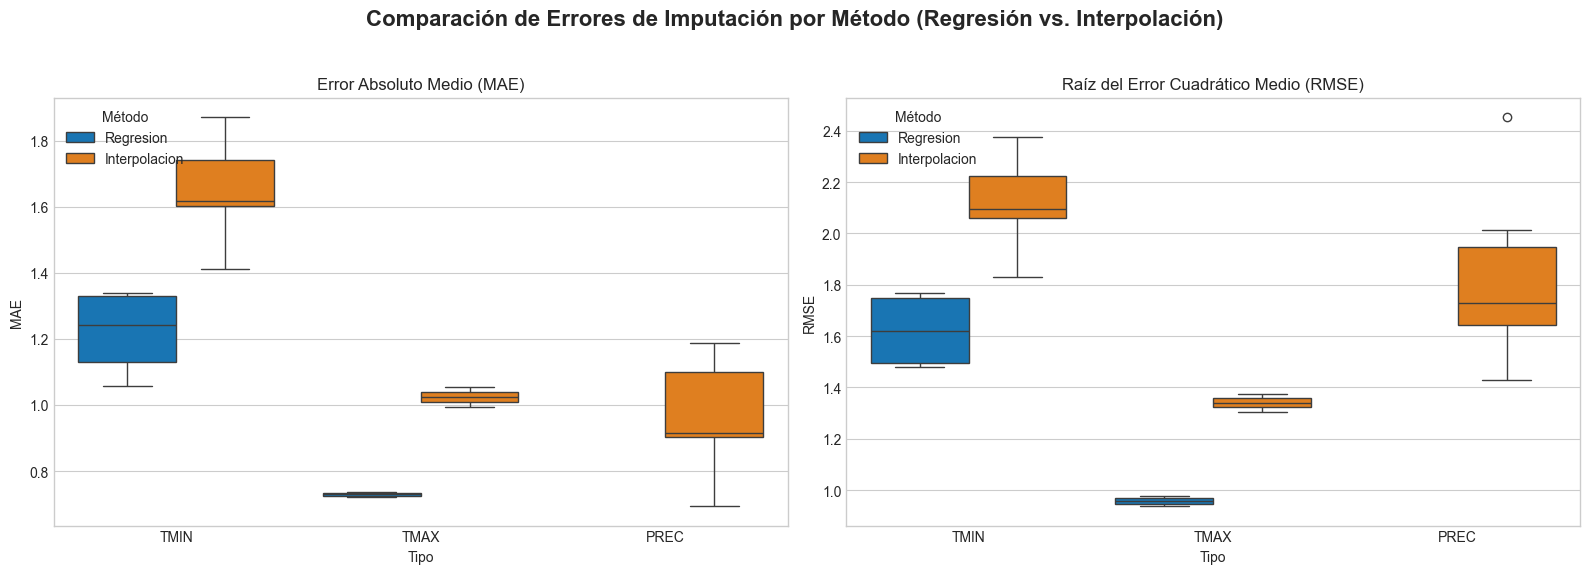

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ==================== CONFIGURACIÓN ====================
# Porcentaje de datos a 'ocultar' y usar para la validación
VALIDATION_FRACTION = 0.05 
# Correlación mínima para considerar una pareja en Regresión
CORR_UMBRAL = 0.75
# Mínimo de puntos para entrenar el modelo de Regresión
MIN_POINTS_REGRESSION = 30
# Semilla aleatoria para reproducibilidad
RANDOM_SEED = 42

# Variables a validar
ALL_VAR_NAMES = ['TMIN', 'TMAX', 'PREC']

# Rangos físicos para recortar predicciones no realistas (usando los de tu script)
RANGOS_FISICOS = {
    'TMIN': (-10, 30),
    'TMAX': (5, 40),
    'PREC': (0, 300)
}

# ==================== FUNCIONES DE UTILIDAD ====================

def obtener_version_archivo(directorio, nombre_base, extension='csv'):
    """Genera un nombre de archivo con versión incremental."""
    archivos_existentes = list(directorio.glob(f"{nombre_base}_v*.{extension}"))
    if not archivos_existentes:
        return f"{nombre_base}_v1.{extension}"
    versiones = []
    for archivo in archivos_existentes:
        try:
            match = re.search(r'_v(\d+)\.' + extension, archivo.name)
            if match:
                versiones.append(int(match.group(1)))
        except:
            continue
    nueva_version = max(versiones) + 1 if versiones else 1
    return f"{nombre_base}_v{nueva_version}.{extension}"

def extraer_tipo_variable(nombre_columna):
    """Extrae el tipo de variable (TMIN, TMAX, PREC) del nombre de columna."""
    return nombre_columna.split('_')[0]

def validar_rangos_fisicos(valores, var_type):
    """Aplica clipping a rangos físicos."""
    if var_type in RANGOS_FISICOS:
        lower, upper = RANGOS_FISICOS[var_type]
        return np.clip(valores, lower, upper)
    return valores

def interpolacion_temporal(serie, limit_days=7):
    """Interpola una serie temporal (lineal con límite de días)."""
    return serie.interpolate(method='linear', limit=limit_days, limit_direction='both')

# ==================== DEFINICIÓN DE RUTAS Y CARGA DE DATOS ====================

base_proyecto = Path.cwd()

# ⚠️ ADAPTACIÓN: Usar tu sistema de rutas para encontrar el archivo de entrada
try:
    import rutas
    dir_input_consolidados = rutas.datos_consolidados
    dir_output_imputacion = rutas.datos_imputados # Usaremos esta como dir_output
    print("✓ Rutas cargadas desde rutas.py")
except ImportError:
    dir_input_consolidados = base_proyecto / "Datos" / "datos_consolidados"
    dir_output_imputacion = base_proyecto 
    print("⚠ rutas.py no encontrado, usando rutas por defecto para validación")
    
# Asegurar que el directorio de salida exista
dir_output_imputacion.mkdir(parents=True, exist_ok=True)
dir_output = dir_output_imputacion # Directorio de salida para reportes

print(f"📂 Buscando archivo de entrada en: {dir_input_consolidados}")


# ----------------- Buscar Archivo de Entrada (Tu Bloque Original) -----------------
file_pattern_input = 'cundinamarca_sin_outliers_IQR_Mensual_v*.csv'
archivos_limpios = sorted(dir_input_consolidados.glob(file_pattern_input))

if not archivos_limpios:
    print(f"\n✗ No se encontró '{file_pattern_input}', buscando alternativas...")
    
    # Intentar con otro patrón
    alternativo = 'cundinamarca_unificado_sin_outliers_v*.csv'
    archivos_limpios = sorted(dir_input_consolidados.glob(alternativo))
    
    if not archivos_limpios:
        # Último intento
        alternativo2 = 'cundinamarca_unificado_v*.csv'
        archivos_limpios = sorted(dir_input_consolidados.glob(alternativo2))
        
        if not archivos_limpios:
            # Fallback a nombre explícito que mencionaste antes
            fallback_name = 'cundinamarca_final_wide_con_nans_v1.csv'
            fallback_path = dir_input_consolidados / fallback_name
            if fallback_path.exists():
                INPUT_FILE_PATH = fallback_path
                print(f"✓ Usando fallback: {fallback_name}")
            else:
                print(f"✗ Tampoco se encontró '{alternativo}', '{alternativo2}' ni '{fallback_name}'")
                raise FileNotFoundError("✗ No se encontró el archivo de datos limpio en la ruta esperada.")
        else:
            INPUT_FILE_PATH = archivos_limpios[-1]
            print(f"✓ Usando patrón alternativo: {alternativo2}")
    else:
        INPUT_FILE_PATH = archivos_limpios[-1]
        print(f"✓ Usando patrón alternativo: {alternativo}")
else:
    INPUT_FILE_PATH = archivos_limpios[-1]

print(f"✓ Archivo de entrada encontrado: {INPUT_FILE_PATH.name}")


# Archivos de salida
OUTPUT_REPORT_NAME = obtener_version_archivo(dir_output, 'validacion_cruzada_reporte_INTEGRAL', 'csv')
OUTPUT_REPORT_PATH = dir_output / OUTPUT_REPORT_NAME
OUTPUT_PLOT_NAME = obtener_version_archivo(dir_output, 'validacion_cruzada_plot_INTEGRAL', 'png')
OUTPUT_PLOT_PATH = dir_output / OUTPUT_PLOT_NAME

# Cargar y preparar datos
df = pd.read_csv(INPUT_FILE_PATH, parse_dates=['Fecha']).set_index('Fecha')
df.columns = [c.upper() for c in df.columns] # Normalizar a mayúsculas
print(f"📊 Dataset cargado. Forma: {df.shape}")

# Calcular matriz de correlación
print("🔄 Calculando matriz de correlación...")
corr_matrix = df.corr(method='pearson')

# ==================== VALIDACIÓN CRUZADA ====================
validation_results = []
np.random.seed(RANDOM_SEED)
model = LinearRegression()

print("\n" + "=" * 60)
print("INICIANDO VALIDACIÓN")
print("=" * 60)

for target_col in df.columns:
    var_type = extraer_tipo_variable(target_col)
    # Usar TMIN/TMAX/PREC en mayúsculas para coincidir con tu configuración
    if var_type not in ALL_VAR_NAMES:
        continue
        
    datos_validos = df[target_col].dropna()
    if len(datos_validos) < 100:
        continue
    
    print(f"\n📍 Validando: {target_col}")

    # --- 1. REGRESIÓN LINEAL ---
    best_partner = None
    best_corr = np.nan
    rmse_regression = mae_regression = r2_regression = np.nan
    
    # MODIFICACIÓN 1: Inicializar como lista vacía
    validation_indices = [] 
    
    # Filtrar por TIPO DE VARIABLE y excluir la columna objetivo
    columnas_mismo_tipo = [c for c in df.columns if extraer_tipo_variable(c) == var_type and c != target_col]
    
    if columnas_mismo_tipo:
        corr_series = corr_matrix.loc[target_col, columnas_mismo_tipo].abs().sort_values(ascending=False)
        candidatos = corr_series[corr_series >= CORR_UMBRAL]
        
        if not candidatos.empty:
            best_partner = candidatos.index[0]
            best_corr = candidatos.iloc[0]
            df_clean = df[[target_col, best_partner]].dropna()
            
            if len(df_clean) >= MIN_POINTS_REGRESSION:
                n_validation = int(len(df_clean) * VALIDATION_FRACTION)
                
                if n_validation >= 10:
                    validation_indices = np.random.choice(df_clean.index, size=n_validation, replace=False)
                    df_train = df_clean.drop(validation_indices)
                    Y_actual = df_clean.loc[validation_indices, target_col].values
                    
                    try:
                        # Ejecutar Regresión
                        X_train = df_train[best_partner].values.reshape(-1, 1)
                        model.fit(X_train, df_train[target_col].values)
                        X_test = df_clean.loc[validation_indices, best_partner].values.reshape(-1, 1)
                        Y_pred_regression = model.predict(X_test)
                        
                        Y_pred_regression = validar_rangos_fisicos(Y_pred_regression, var_type)
                        
                        rmse_regression = np.sqrt(mean_squared_error(Y_actual, Y_pred_regression))
                        mae_regression = mean_absolute_error(Y_actual, Y_pred_regression)
                        r2_regression = r2_score(Y_actual, Y_pred_regression)
                        
                        print(f"    📊 Regresión (r={best_corr:.3f}): MAE={mae_regression:.3f}, R²={r2_regression:.3f}")
                        
                    except Exception as e:
                        print(f"    ✗ Error en regresión para {target_col}: {e}")

    # --- 2. INTERPOLACIÓN ---
    rmse_interpolation = mae_interpolation = r2_interpolation = np.nan
    
    # MODIFICACIÓN 2: Corregir la verificación de índices vacíos
    # Si es una lista o np.array, verificar su longitud o si está vacío.
    if isinstance(validation_indices, np.ndarray):
        indices_vacio = validation_indices.size == 0
    else:
        indices_vacio = not validation_indices
        
    if indices_vacio:
         n_validation_interp = int(len(datos_validos) * VALIDATION_FRACTION)
         if n_validation_interp >= 10:
             validation_indices = np.random.choice(datos_validos.index, size=n_validation_interp, replace=False)
         else:
             print(f"    ⚠️ Set validación (interp) muy pequeño.")
             continue
    
    try:
        # Asegurar que validation_indices es un objeto indexable (como una lista o un array)
        if not isinstance(validation_indices, (list, np.ndarray, pd.Index)):
             continue # Saltar si no es un índice válido
             
        Y_actual_full = df[target_col].loc[validation_indices].values
        serie_simulada = df[target_col].copy()
        serie_simulada.loc[validation_indices] = np.nan
        
        serie_interpolada = interpolacion_temporal(serie_simulada, limit_days=7)
        Y_pred_interpolation = serie_interpolada.loc[validation_indices].values
        
        mask_valid = ~np.isnan(Y_pred_interpolation)
        
        if mask_valid.sum() >= 5:
            Y_actual_interp = Y_actual_full[mask_valid]
            Y_pred_interp_valid = Y_pred_interpolation[mask_valid]
            
            Y_pred_interp_valid = validar_rangos_fisicos(Y_pred_interp_valid, var_type)
            
            rmse_interpolation = np.sqrt(mean_squared_error(Y_actual_interp, Y_pred_interp_valid))
            mae_interpolation = mean_absolute_error(Y_actual_interp, Y_pred_interp_valid)
            r2_interpolation = r2_score(Y_actual_interp, Y_pred_interp_valid)
            
            print(f"    📊 Interpolación: MAE={mae_interpolation:.3f}, R²={r2_interpolation:.3f}")
            
        else:
            print(f"    ⚠️ Interpolación no pudo cubrir suficientes valores")
            
    except Exception as e:
        print(f"    ✗ Error en interpolación para {target_col}: {e}")
    
    # --- GUARDAR RESULTADOS ---
    validation_results.append({
        'Variable': target_col,
        'Tipo': var_type,
        'N_Validacion': len(validation_indices),
        'Mejor_Pareja': best_partner,
        'Correlacion': best_corr,
        'RMSE_Regresion': rmse_regression,
        'MAE_Regresion': mae_regression,
        'R2_Regresion': r2_regression,
        'RMSE_Interpolacion': rmse_interpolation,
        'MAE_Interpolacion': mae_interpolation,
        # R2 no es una métrica estándar para interpolación
        'R2_Interpolacion': np.nan 
    })

# ==================== GENERAR REPORTE Y GRÁFICOS ====================

if not validation_results:
    print("\n✗ No se pudieron validar columnas.")
    exit()

df_report = pd.DataFrame(validation_results)

# Guardar CSV
df_report.to_csv(OUTPUT_REPORT_PATH, index=False, encoding='utf-8-sig')
print(f"\n💾 Reporte CSV guardado: {OUTPUT_REPORT_NAME}")

# Preparar datos para los gráficos
df_plot = df_report.copy()
df_plot = df_plot[(df_plot['MAE_Regresion'].notna()) | (df_plot['MAE_Interpolacion'].notna())].reset_index(drop=True)

# Derretir el DataFrame para Boxplots MAE
df_mae_melt = df_plot.melt(
    id_vars=['Tipo'], 
    value_vars=['MAE_Regresion', 'MAE_Interpolacion'],
    var_name='Metodo', 
    value_name='MAE'
).dropna(subset=['MAE'])
df_mae_melt['Metodo'] = df_mae_melt['Metodo'].str.replace('MAE_', '')

# Derretir el DataFrame para Boxplots RMSE
df_rmse_melt = df_plot.melt(
    id_vars=['Tipo'], 
    value_vars=['RMSE_Regresion', 'RMSE_Interpolacion'],
    var_name='Metodo', 
    value_name='RMSE'
).dropna(subset=['RMSE'])
df_rmse_melt['Metodo'] = df_rmse_melt['Metodo'].str.replace('RMSE_', '')

# Generar gráficos
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Comparación de Errores de Imputación por Método (Regresión vs. Interpolación)', fontsize=16, fontweight='bold')

# Gráfico 1: MAE por tipo y método
sns.boxplot(data=df_mae_melt, x='Tipo', y='MAE', hue='Metodo', ax=axes[0], palette=['#007ACC', '#FF7F00'])
axes[0].set_title('Error Absoluto Medio (MAE)')
axes[0].set_ylabel('MAE')
axes[0].legend(title='Método', loc='upper left')

# Gráfico 2: RMSE por tipo y método
sns.boxplot(data=df_rmse_melt, x='Tipo', y='RMSE', hue='Metodo', ax=axes[1], palette=['#007ACC', '#FF7F00'])
axes[1].set_title('Raíz del Error Cuadrático Medio (RMSE)')
axes[1].set_ylabel('RMSE')
axes[1].legend(title='Método', loc='upper left')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(OUTPUT_PLOT_PATH, dpi=300, bbox_inches='tight')
print(f"💾 Gráficos guardados: {OUTPUT_PLOT_NAME}")
# plt.show() # Descomenta para ver la ventana emergente del gráfico

print("\n" + "=" * 60)
print("✅ VALIDACIÓN COMPLETADA")
print("=" * 60)

reporte imputacion

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import re

# ==================== DEFINICIÓN DE RUTAS ====================
base_proyecto = Path.cwd()

try:
    # Importar las rutas definidas por el usuario
    import rutas
    # El archivo de entrada para el chequeo de calidad es el archivo final imputado,
    # que se guarda en el directorio de salida de la imputación.
    dir_output_imputacion = rutas.datos_imputados
    print("✓ Rutas cargadas desde rutas.py")
except ImportError:
    # Fallback si rutas.py no está disponible (asume el CWD o una ruta por defecto)
    dir_output_imputacion = base_proyecto / "Datos_Imputados"
    if not dir_output_imputacion.exists():
        dir_output_imputacion = base_proyecto
    print("⚠ rutas.py no encontrado, usando el directorio actual como ruta de búsqueda.")

# ----------------- Buscar Archivo Final Imputado -----------------
file_pattern_final = 'cundinamarca_imputado_v*.csv'
archivos_imputados = sorted(dir_output_imputacion.glob(file_pattern_final))

if not archivos_imputados:
    raise FileNotFoundError(f"❌ ERROR: No se encontró ningún archivo final que coincida con el patrón '{file_pattern_final}' en: {dir_output_imputacion}")

INPUT_FINAL_FILE_PATH = archivos_imputados[-1] # Tomar la versión más reciente
INPUT_FINAL_FILE = INPUT_FINAL_FILE_PATH.name 

# ==================== CONFIGURACIÓN DEL CHEQUEO ====================
RANGOS_FISICOS = {
    'TMin': (-10, 30),
    'TMax': (5, 40),
    'PREC': (0, 300) 
    # Solo chequeamos las variables principales (TMin, TMax, PREC)
}

# ==================== FUNCIONES DE UTILIDAD ====================

def extraer_tipo_variable(nombre_columna):
    """Extrae el tipo de variable (TMin, TMax, PREC) del nombre de columna."""
    if nombre_columna.upper().startswith('TMIN'): return 'TMin'
    if nombre_columna.upper().startswith('TMAX'): return 'TMax'
    if nombre_columna.upper().startswith('PREC'): return 'PREC'
    return None

def validar_tmin_tmax_check(df):
    """Verifica que TMin < TMax para cada estación en cada fecha."""
    inconsistencias = 0
    tmin_cols = [c for c in df.columns if c.startswith('TMin_')]
    tmax_cols = [c for c in df.columns if c.startswith('TMax_')]
    
    estaciones = set(c.replace('TMin_', '') for c in tmin_cols)
    
    for estacion in estaciones:
        tmin_col = f'TMin_{estacion}'
        tmax_col = f'TMax_{estacion}'
        
        if tmin_col in df.columns and tmax_col in df.columns:
            # Contar filas donde TMin > TMax, ignorando NaNs
            mask_invalid = (df[tmin_col].notnull()) & (df[tmax_col].notnull()) & (df[tmin_col] > df[tmax_col])
            inconsistencias += mask_invalid.sum()
            
    return inconsistencias

# ==================== PROCESO DE VERIFICACIÓN ====================

try:
    print(f"\n{'='*60}")
    print(f"INICIANDO CHEQUEO DE CALIDAD PARA {INPUT_FINAL_FILE}")
    print(f"Ruta: {INPUT_FINAL_FILE_PATH.parent}")
    print(f"{'='*60}")
    
    # 1. Cargar el DataFrame final
    df_final = pd.read_csv(INPUT_FINAL_FILE_PATH, parse_dates=['Fecha']).set_index('Fecha')
    
    print(f"📊 Dataset final cargado. Forma: {df_final.shape}")
    
    # --- 1. VERIFICAR NaNs RESIDUALES ---
    print("\n--- 1. NaNs Residuales ---")
    nans_finales = df_final.isnull().sum().sum()
    
    if nans_finales == 0:
        print("🎉 ¡RESULTADO: 100% SIN NaNs! La imputación fue TOTAL.")
    else:
        total_elements = df_final.size
        porcentaje_nans = nans_finales / total_elements * 100
        print(f"⚠️ RESULTADO: Quedan {nans_finales:,} NaNs ({porcentaje_nans:.2f}%) residuales.")
        # ... (detalle de NaNs)
    
    # --- 2. VALIDAR RANGOS FÍSICOS ---
    print("\n--- 2. Validación de Rangos Físicos ---")
    problemas_rango = 0
    
    for col in df_final.columns:
        var_type = extraer_tipo_variable(col)
        if var_type in RANGOS_FISICOS:
            lower, upper = RANGOS_FISICOS[var_type]
            fuera = ((df_final[col].notnull()) & ((df_final[col] < lower) | (df_final[col] > upper))).sum()
            
            if fuera > 0:
                print(f"   ❌ {col} ({var_type}): {fuera} valores fuera de rango [{lower}, {upper}]")
                problemas_rango += fuera
    
    if problemas_rango == 0:
        print("   ✅ Todos los valores están dentro de rangos válidos.")
    else:
        print(f"   ⚠️ Total de valores fuera de rango: {problemas_rango:,}")
        
    # --- 3. VALIDAR CONSISTENCIA TMin < TMax ---
    print("\n--- 3. Validación TMin vs TMax ---")
    problemas_tmin_tmax = validar_tmin_tmax_check(df_final)
    
    if problemas_tmin_tmax == 0:
        print("   ✅ TMin < TMax se cumple en todas las fechas para todas las estaciones.")
    else:
        print(f"   ❌ Se encontraron {problemas_tmin_tmax} inconsistencias (TMin > TMax).")

    print(f"\n{'='*60}")
    print("CHEQUEO DE CALIDAD FINALIZADO")
    print(f"{'='*60}")
    
except FileNotFoundError as e:
    print(f"\n❌ ERROR: Archivo no encontrado. {e}")
    print(f"Asegúrate de que el archivo final imputado esté en el directorio: {dir_output_imputacion}")
except Exception as e:
    print(f"\n❌ Ocurrió un error inesperado durante la verificación: {e}")

✓ Rutas cargadas desde rutas.py

INICIANDO CHEQUEO DE CALIDAD PARA cundinamarca_imputado_v1.csv
Ruta: D:\Documentos\1especializacion\proyecto\proyecto_heladas_Madrid\Datos\datos_imputados
📊 Dataset final cargado. Forma: (10971, 15)

--- 1. NaNs Residuales ---
🎉 ¡RESULTADO: 100% SIN NaNs! La imputación fue TOTAL.

--- 2. Validación de Rangos Físicos ---
   ✅ Todos los valores están dentro de rangos válidos.

--- 3. Validación TMin vs TMax ---
   ✅ TMin < TMax se cumple en todas las fechas para todas las estaciones.

CHEQUEO DE CALIDAD FINALIZADO
